# Transportation Demand Forecasting with Granite Time Series - Zero-shot Inference and Fine-tuning with Exogenous Inputs

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multivariate forecasts.

In this recipe, we cover zero-shot forecasting, as well as fine-tuning. This example makes use of the Kaggle bike sharing [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) which contains bikes rental demand with weather and seasonal information.

## Setting Up

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install a tested version of the library.

In [ ]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==v0.2.22" -U

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function. We also leverage a few components for the fine-tuning process.


In [ ]:
import math
import os

import numpy as np
import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [ ]:
# TTM model branch
# Use main for 512-96 model
# Use "1024-96-r2" for 1024-96 model
# Use "512-96-ft-r2.1" for 512-96 r2.1 model
TTM_MODEL_REVISION = "main"
context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max prediction length for the 512-96 model

# Output directory for writing evaluation results.
OUT_DIR = "/tmp/ttm_results"

## Preparing the Data

### Download the data

We'll work with a [bike sharing datasety](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) available from the UCI Machine learning repository. This dataset includes the count of rental bikes between the years 2011 and 2012 in the Capital bike share system with the corresponding weather and seasonal information.

You can download the source code to a temporary directory by running the following commands. Later you can clean up any downloaded files by removing the `temp` folder.

In [ ]:
%%bash
# curl https://archive.ics.uci.edu/static/public/275/$BIKE_SHARING -o $BIKE_SHARING && \
BIKE_SHARING=bike+sharing+dataset.zip
test -d temp || ( \
  mkdir -p temp && \
  cd temp && \
    wget https://archive.ics.uci.edu/static/public/275/$BIKE_SHARING -O $BIKE_SHARING && \
    unzip -o $BIKE_SHARING && \
  rm -f $BIKE_SHARING && \
  cd - \
) && ls -l temp/

In [ ]:
DATA_FILE_PATH = "temp/hour.csv"

### Read in the data

We parse the CSV into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a UTC datetime.

In [ ]:
timestamp_column = "dteday"
target_columns = ["casual", "registered", "cnt"]

# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Fix missing hours in original dataset date column
input_df[timestamp_column] = input_df[timestamp_column] + input_df.hr.apply(lambda x: pd.Timedelta(x, unit="hr"))

# Show the last few rows of the dataset.
input_df.tail()

### Plot a segment of the target series

Here we inspect a preview of the target time series.

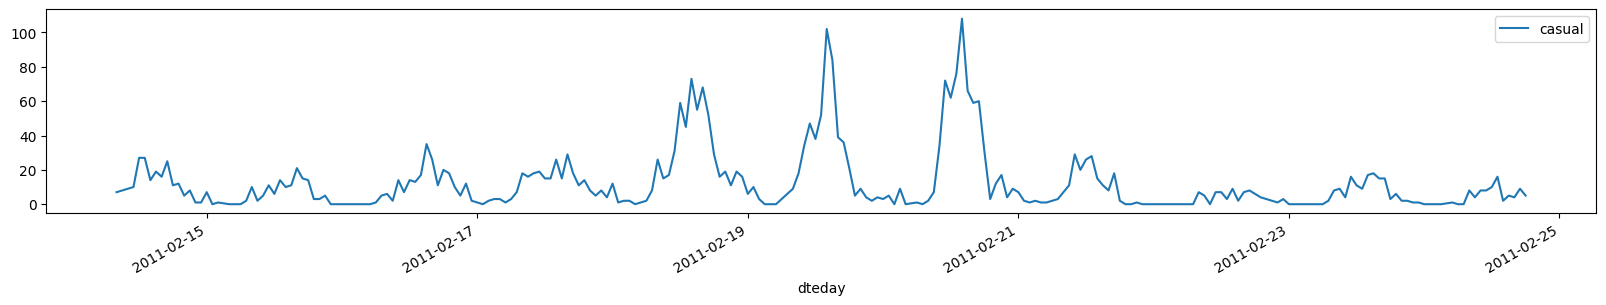

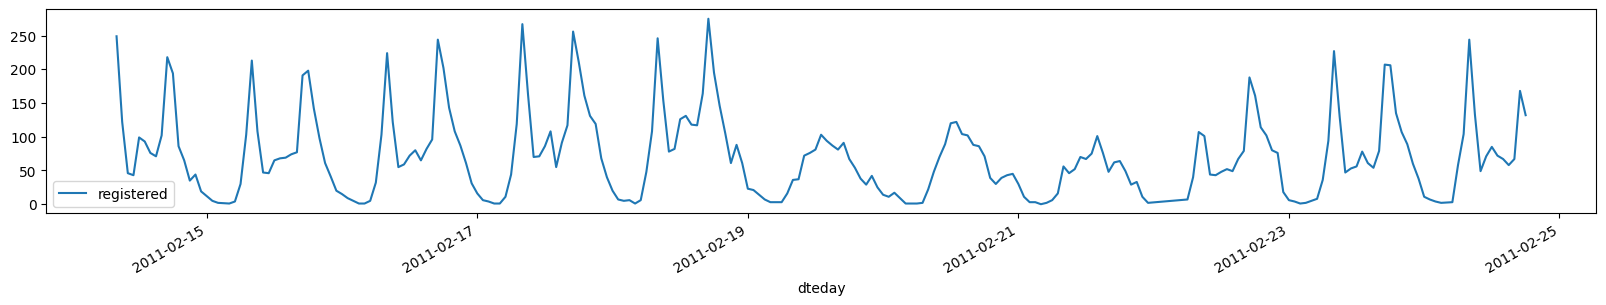

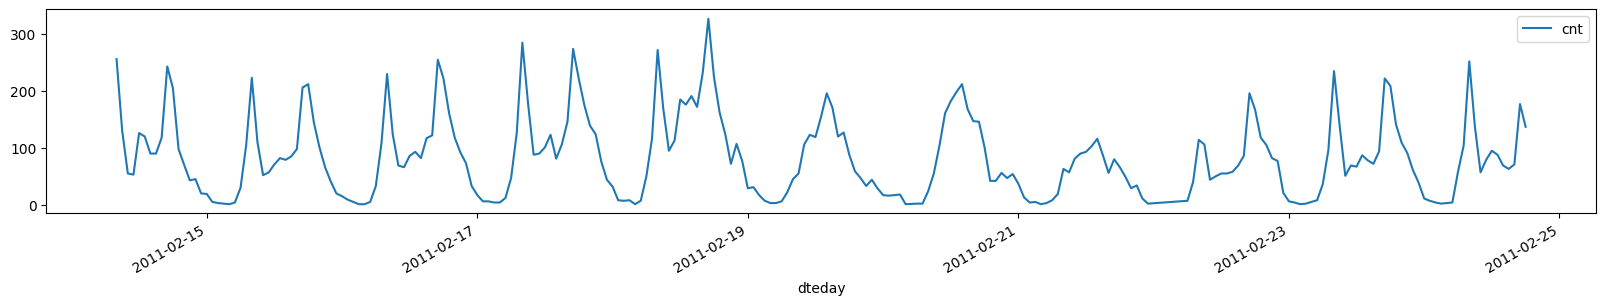

In [ ]:
for target_column in target_columns:
    input_df.iloc[1000 : 1000 + 24 * 10].plot(x=timestamp_column, y=target_column, figsize=(20, 3))

## Zero shot forecasting

In the first part of this notebook, we focus on zero-shot inference of the targets only. This does not consider the relationships between the targets or any of the additional exogenous features in the dataset.

### Split the data into training, validation, and testing sets

We split the data into training, validation, and test sets. The training set is used to train the preprocessor, while the test set is used to evaluate the model performance.

In [ ]:
split_config = {"train": 0.5, "test": 0.25}

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)
print(f"Data lengths: train = {len(train_df)}, val = {len(valid_df)}, test = {len(test_df)}")

### Train the Preprocessor

The preprocessor is trained on the training portion of the input data to learn the scaling factors. The scaling will be applied when we use the preprocess method of the time series preprocessor.

In [ ]:
tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    scaler_type="standard",
)

trained_tsp = tsp.train(train_df)

### Generate zero-shot forecasts and evaluate

To generate forecasts from the zero-shot model we first load the model and then configure a TimeSeriesForecastingPipeline. The pipeline is responsible for using the zero-shot model and the preprocessor to create forecasts and output the results.

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on HuggingFace.
    revision=TTM_MODEL_REVISION,
    num_input_channels=len(target_columns),  # Number of input columns.
)

In [ ]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
    batch_size=512,
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(test_df)
zeroshot_forecast.head()

In [ ]:
# Define some standard metrics.
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


custom_metric(zeroshot_forecast["cnt"], zeroshot_forecast["cnt_prediction"], "zero-shot forecast")

,zero-shot forecast
mean_squared_error,18092.303554
root_mean_squared_error,134.507634
mean_absolute_error,91.819151


### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

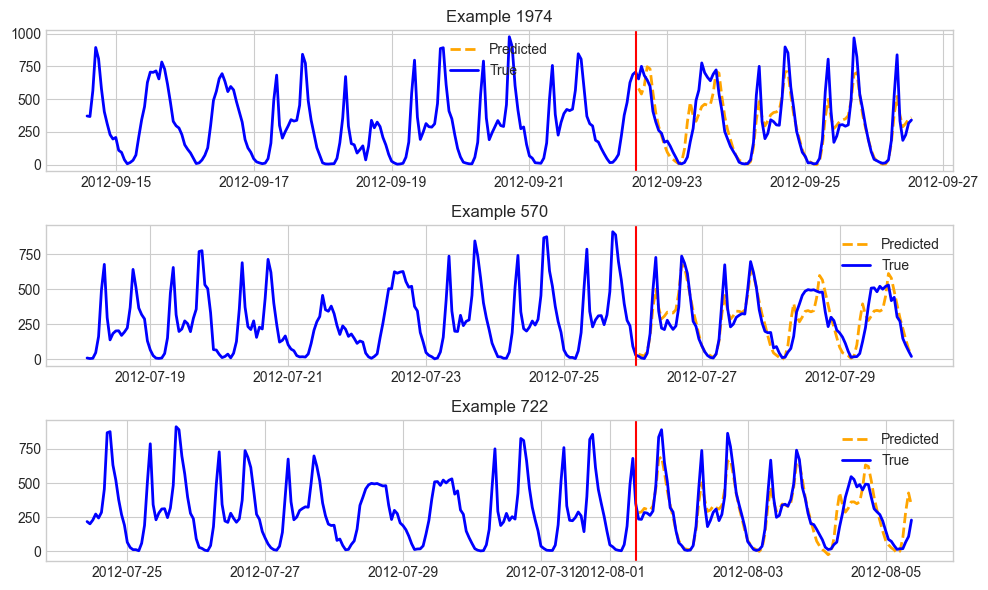

In [ ]:
plot_predictions(
    input_df=test_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_columns[2],
    indices=[1974, 570, 722],
)

## Fine-tuning the model

In this part of this notebook, we focus on fine-tuning the pretrained model. We use the same data splits we defined above, but now include extra columns during the fine-tuning process.

### Configure columns and preprocessor for fine-tuning

We define the control columns or features whose values will be known into the future, and set up the time series preprocessor.

In [ ]:
SEED = 42
set_seed(SEED)

control_columns = [
    "season",
    "yr",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]

tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    target_columns=target_columns,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

### Load the model for fine-tuning
Similar to the zero-shot case, we load the TTM model available on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1). We have three target channels and several exogenous channels in this example and set configuration appropriately take this into accounts. Note that we also enable channel mixing in the decoder and forecast channel mising. This allows the decoder to be tuned to capture interactions between the channels as well as adjust the forecasts based on interactions with the exogenous.

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",
    revision=TTM_MODEL_REVISION,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)

### Freeze the TTM Backbone

During fine-tuning we freeze the backbone and focus on tuning only the parameters in the decoder. This reduces the overall number of parameters being tuned and maintains what the encoder learned during pretraining.

In [ ]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 867631
Number of params after freezing the backbone 314693


### Get the datasets for fine tuning

We use the `get_datasets` function in conjunction with the time series preprocessor. We split the data into training, validation, and test sets. The training set is used to train the model, while the test set is used to evaluate its performance. Note that we inspect the `resolution_prefix_tuning` attribute of the model config to enable the frequency token if needed.

In [ ]:
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, input_df, split_config, use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

### Set up a Trainer for Fine-tuning

Configure a Trainer for use in fine-tuning and evaluating the model. 

In [ ]:
# Important parameters
learning_rate = 0.000298  # 0.000298364724028334
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=4,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=True,  # Remove when GPU is available
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

### Train the Model

Here we train the model on the training data. This tunes only the weights in the decoder and output layers, as the other weights have been frozen, taking into account the interactions between all the channels.


In [ ]:
# Fine tune
finetune_forecast_trainer.train()

INFO:p-45749:t-8706885696:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-45750:t-8706885696:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-45752:t-8706885696:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-45754:t-8706885696:config.py:<module>:PyTorch version 2.6.0 available.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [ ]:
# generate forecasts using the finetuned model
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
    batch_size=batch_size,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(test_df)
finetune_forecast.head()

In [ ]:
custom_metric(finetune_forecast["cnt"], finetune_forecast["cnt_prediction"], "fine-tune forecast")

,fine-tune forecast
mean_squared_error,15776.505766
root_mean_squared_error,125.604561
mean_absolute_error,86.827456


### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

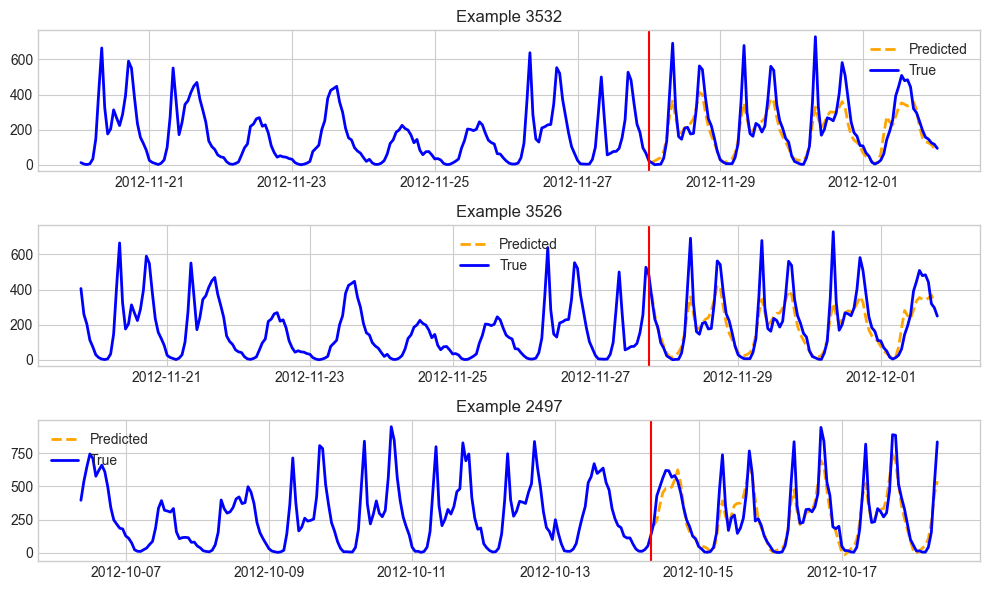

In [ ]:
# plot
plot_predictions(
    input_df=test_df,
    predictions_df=finetune_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_columns[2],
    indices=[3532, 3526, 2497],
)

## Making the Forecast

### Create a forecasting pipeline with the fine-tuned model

We extract the appropriate historical data (context) and future values of control variables, and then set up the forecasting pipeline with the model and time series preprocessor.

We choose a context window near the end of the test dataset, while still leaving enough known data from which we extract the controls. This is meant to simulate the case where you have historical information for the inputs and also provide future values of the controls.

In [ ]:
historical_df = test_df.iloc[-prediction_length - context_length : -prediction_length].copy()
controls_df = test_df.iloc[-prediction_length:][[timestamp_column] + control_columns].copy()

# generate forecasts using the finetuned model
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(historical_df, future_time_series=controls_df)

In [ ]:
finetune_forecast

### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern.

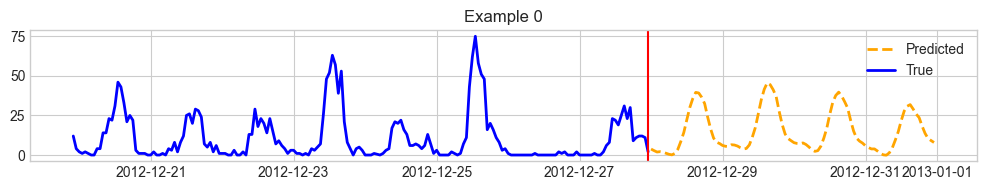

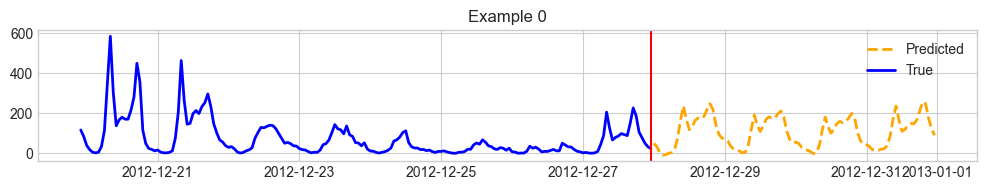

In [ ]:
# Pre-cast the timestamp to avoid future dtype inference changes
historical_df[timestamp_column] = pd.to_datetime(historical_df[timestamp_column])

# Plot the historical data and predicted series.
plot_predictions(
    input_df=historical_df,
    predictions_df=finetune_forecast,
    freq=tsp.freq,
    timestamp_column=timestamp_column,
    channel=target_columns[0],
)
plot_predictions(
    input_df=historical_df,
    predictions_df=finetune_forecast,
    freq=tsp.freq,
    timestamp_column=timestamp_column,
    channel=target_columns[1],
)

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: [Bike Sharing Dataset on Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset)